In [1]:
# this notebook expands on the latent-space-q-name.ipynb notebook
# but training both the amplitude and phase and comparing matches

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import wispy.waveutils
import wispy.model_utils

In [3]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [4]:

# "/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data"

# "/Users/spx8sk/work/data/wispy-data/add_phenC/training_data"

In [5]:
# training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data")
training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/training_data")

In [6]:
# validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/validation_data")
validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/validation_data")

In [7]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [8]:
training_data['mask']

{'IMRPhenomC': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299]),
 'IMRPhenomD': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89

In [9]:
def get_training_data(data, data_name):
    x_tmp = {}
    y_tmp = {}
    for i, approx in enumerate(data['unique_approximants']):
        print(f"working {approx}")
        mask = data['mask'][approx]
        num_cases = len(mask)
        qs = data['mass_ratios'][mask]
        names = np.repeat(i, num_cases)
        x_tmp[approx] = np.transpose((names, qs))
        y_tmp[approx] = data[data_name][mask]
        
    x = np.row_stack([x_tmp[approx] for approx in x_tmp.keys()])
    y = np.row_stack([y_tmp[approx] for approx in y_tmp.keys()])
    
    return x, y

In [10]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [11]:
def setup_modelling(data_name, training_data, validation_data, skip=False):
    print(f"data_name: {data_name}")
    x, y = get_training_data(training_data, data_name)
    xval, yval = get_training_data(validation_data, data_name)
    
    NR_NUM = float(np.where(training_data["unique_approximants"]=="NR")[0][0])
    print(NR_NUM)

    sample_weight = np.ones(len(y),)
    sample_weight[x[:,0]==NR_NUM] = 10
    
    output_shape = y.shape[1]
    input_shape = x.shape[1]
    

    units = [16, 128, 512]
    acts = ['relu', 'relu', 'relu']

    # units = [16, 128]
    # acts = ['relu', 'relu']

    # units = [16, 128, 128, 128]
    # acts = ['relu', 'relu', 'relu', 'relu']

    print(f"input_shape = {input_shape}")
    print(f"output_shape = {output_shape}")
    
    model = build_decoder(input_shape, output_shape, units, acts, skip=skip)
    
    return model, dict(x=x, y=y, xval=xval, yval=yval, sample_weight=sample_weight)

In [12]:
times = training_data['times']

In [13]:
model_amp, amplitude_training_data = setup_modelling("amplitude", training_data, validation_data, skip=False)

data_name: amplitude
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
2.0
input_shape = 2
output_shape = 4150


In [14]:
model_phase, phase_training_data = setup_modelling("phase", training_data, validation_data, skip=False)

data_name: phase
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
2.0
input_shape = 2
output_shape = 4150


In [15]:
amplitude_training_data['x'].shape

(305, 2)

In [16]:
amplitude_training_data['y'].shape

(305, 4150)

In [17]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_mse'], label='val_mse')

    plt.yscale('log')
    plt.legend()
    
    return history, model

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 58min 35s, sys: 9min 7s, total: 1h 7min 43s
Wall time: 16min 43s


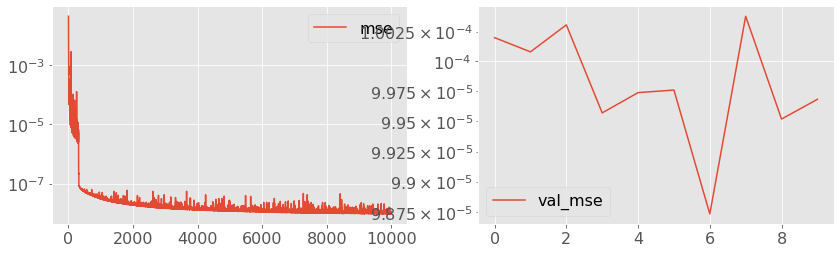

In [18]:
%%time
amp_history, model_amp = initial_fit(
    model_amp,
    x=amplitude_training_data['x'],
    y=amplitude_training_data['y'],
    validation_data=(amplitude_training_data['xval'], amplitude_training_data['yval']),
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=amplitude_training_data['sample_weight']
)

Training:   0%|           0/10000 ETA: ?s,  ?epochs/s

CPU times: user 58min 30s, sys: 9min 36s, total: 1h 8min 6s
Wall time: 16min 49s


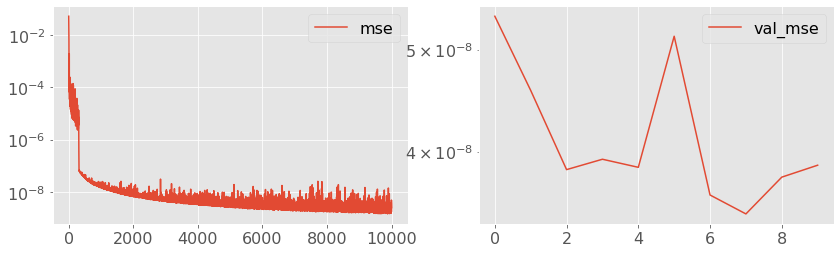

In [19]:
%%time
phase_history, model_phase = initial_fit(
    model_phase,
    x=phase_training_data['x'],
    y=phase_training_data['y'],
    validation_data=(phase_training_data['xval'], phase_training_data['yval']),
    epochs=10000,
    batch_size=20,
    validation_freq=1000,
    lr=None,
    sample_weight=phase_training_data['sample_weight']
)

In [20]:
def compare_models(model, x, y, index, times=times):
    
    yhat = model.predict(x)[index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

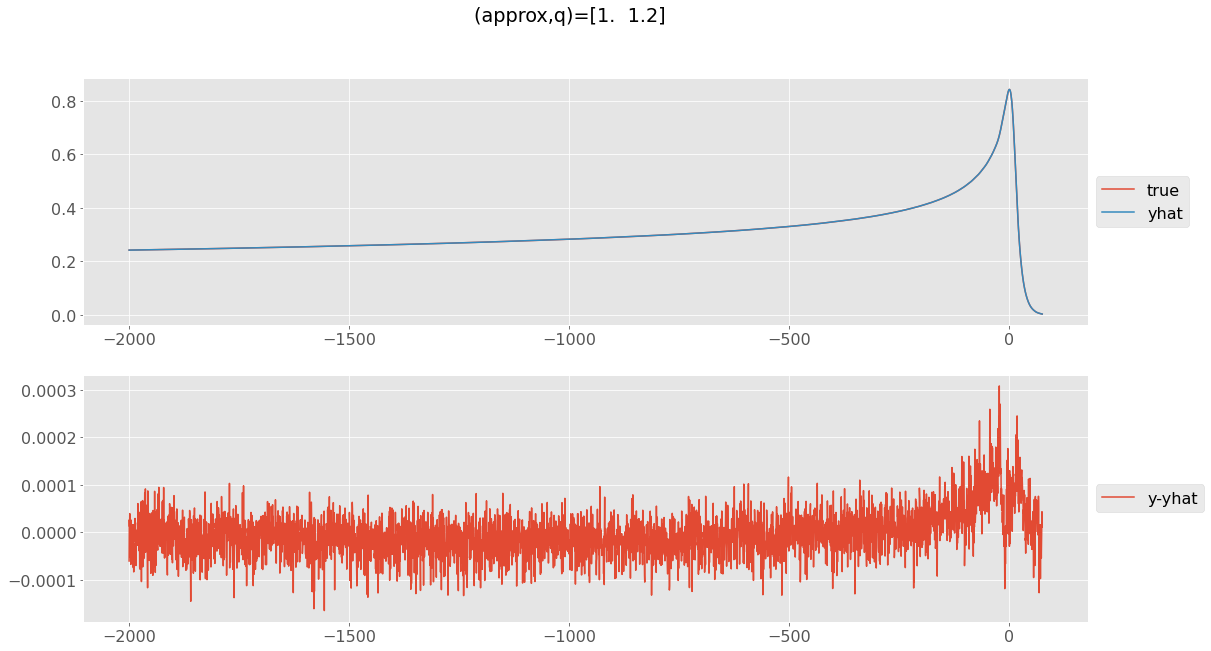

In [21]:
compare_models(model_amp, amplitude_training_data['x'], amplitude_training_data['y'], 102)

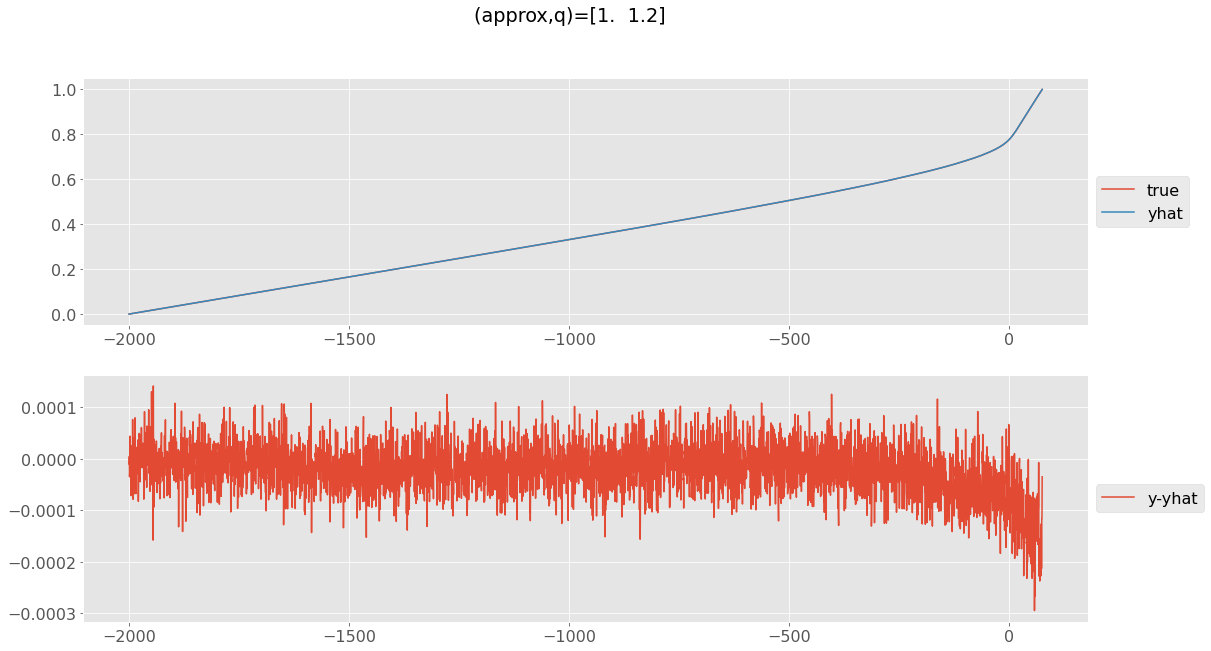

In [22]:
compare_models(model_phase, phase_training_data['x'], phase_training_data['y'], 102)

In [23]:
def predict(model, qs, ns, times=times):
    """
    qs: 1d array of mass-ratios
    ns: 1d array of model numbers ranging from 0 to 2, inclusive
    """
    
    inputs = np.column_stack((ns, qs))
    
    yhats = model.predict(inputs)
    
    plt.figure(figsize=(18, 8))
    for yhat in yhats:
        plt.plot(times, yhat)
#     plt.yscale('log')
#     plt.xlim(-100, 20)
#     plt.ylim(0.4, 0.96)
    plt.show()
    plt.close()

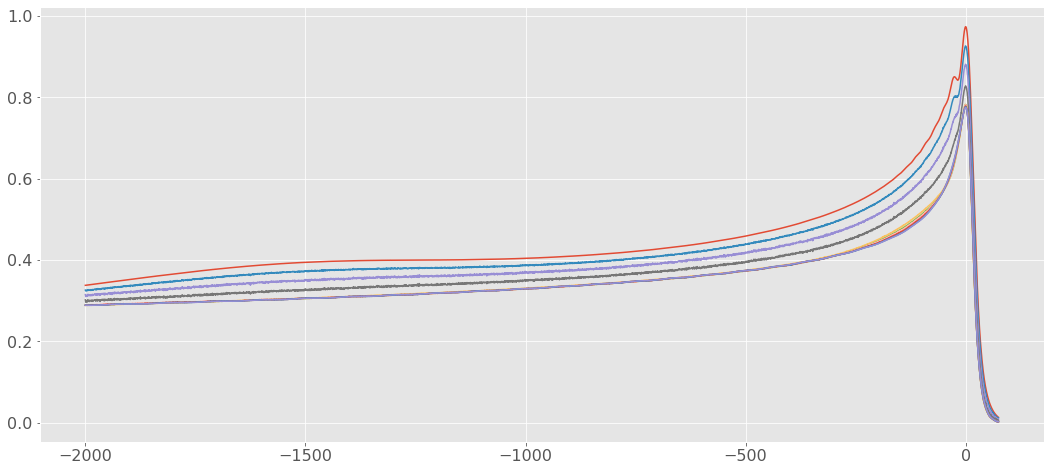

In [24]:
# fixed mass-ratio, and varying model dimension
qs = np.repeat(10., 10)
ns = np.linspace(0, 2, len(qs))
# ns = np.linspace(1, 3, len(qs))
# qs = np.repeat(3, 3)
# ns = np.array([0,1,2])
predict(model_amp, qs, ns)

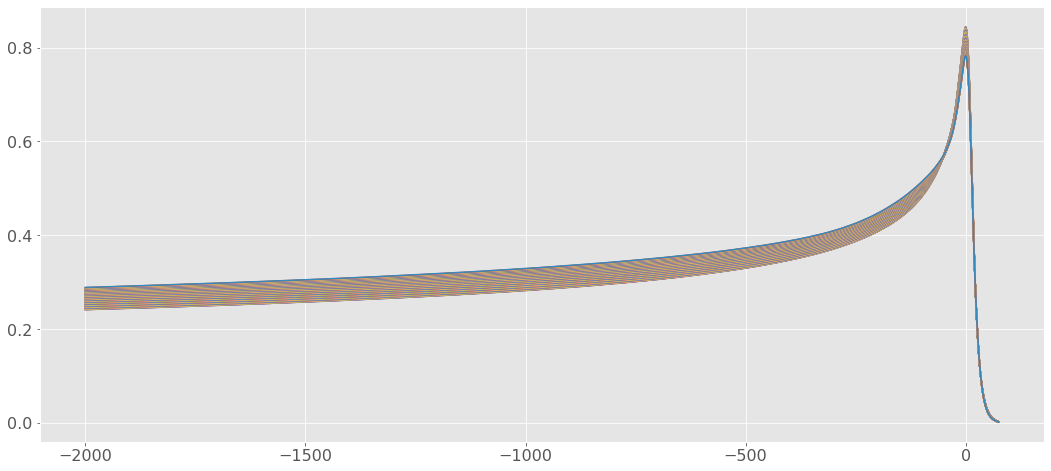

In [25]:
# fixed model dimension, and varying mass-ratio
qs = np.linspace(1, 10, 100)
ns = np.repeat(1, len(qs))
predict(model_amp, qs, ns)

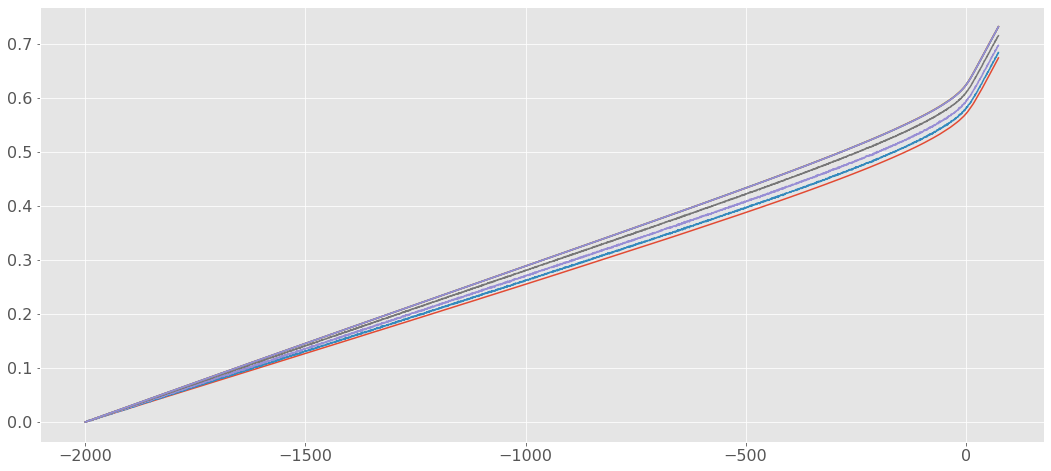

In [26]:
# fixed mass-ratio, and varying model dimension
qs = np.repeat(10, 10)
ns = np.linspace(0, 2, len(qs))
# ns = np.linspace(1, 2, len(qs))
# qs = np.repeat(3, 3)
# ns = np.array([0,1,2])
predict(model_phase, qs, ns)

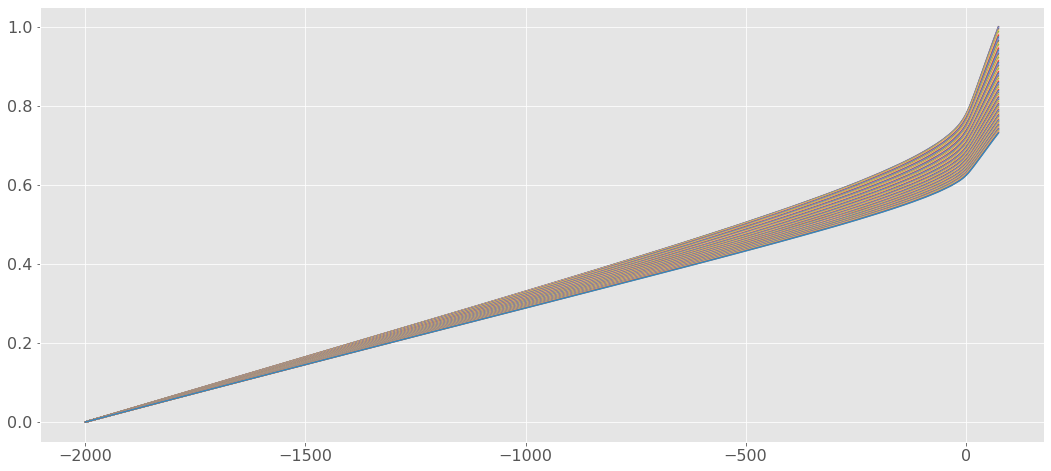

In [27]:
# fixed model dimension, and varying mass-ratio
qs = np.linspace(1, 10, 100)
ns = np.repeat(1, len(qs))
predict(model_phase, qs, ns)

# adding back in the pre-processing scale

In [28]:
training_data['data_processing_params']['tc']

array(2001.)

In [29]:
training_data['data_processing_params']['phase_scale']

array(-929.68)

In [30]:
training_data['data_processing_params']['amp_scale']

array(1.88)

In [31]:
validation_data['data_processing_params']['amp_scale']

array(1.83)

In [32]:
validation_data['data_processing_params']['phase_scale']

array(-929.68)

In [33]:
tc=training_data['data_processing_params']['tc']
amp_scale=training_data['data_processing_params']['amp_scale']
phase_scale=training_data['data_processing_params']['phase_scale']

In [34]:
def predict_wave(n, q, tc=tc, amp_scale=amp_scale, phase_scale=phase_scale, model_amp=model_amp, model_phase=model_phase, times=times, scale_data=True):
    """
    qs: 1d array of mass-ratios
    ns: 1d array of model numbers ranging from 0 to 2, inclusive
    """
    
    q = np.atleast_1d(q)
    n = np.atleast_1d(n)
    
#     print(n, q)
    
    inputs = np.column_stack((n, q))
    
#     print(inputs)
    
    amp = model_amp.predict(inputs)
    phase = model_phase.predict(inputs)
    
    eta = phenom.eta_from_q(q)[:,np.newaxis]
    
    if scale_data:
        t3_leading = wispy.waveutils.taylorT3_leading_term(times, eta, tc)
        phase = phase * t3_leading
        phase = phase * phase_scale
        amp = amp * amp_scale * eta
    
    
    h = amp * np.exp(-1.j*phase)
#     return np.real(h)
    return h, amp, phase

In [35]:
# h_hat, amp_hat, phase_hat = predict_wave([0, 1, 2], [1,1,1])
h_hat, amp_hat, phase_hat = predict_wave([0, 1, 2, 3], [1,1,1,1])

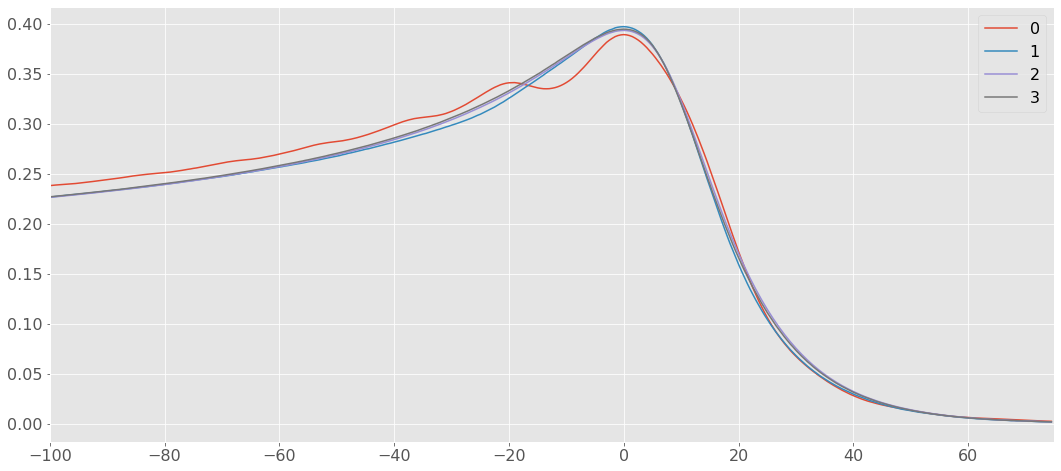

In [36]:
plt.figure(figsize=(18, 8))
plt.plot(times, np.abs(h_hat[0]), label='0')
plt.plot(times, np.abs(h_hat[1]), label='1')
plt.plot(times, np.abs(h_hat[2]), label='2')
plt.plot(times, np.abs(h_hat[3]), label='3')
plt.xlim(-100, 75)
plt.legend()

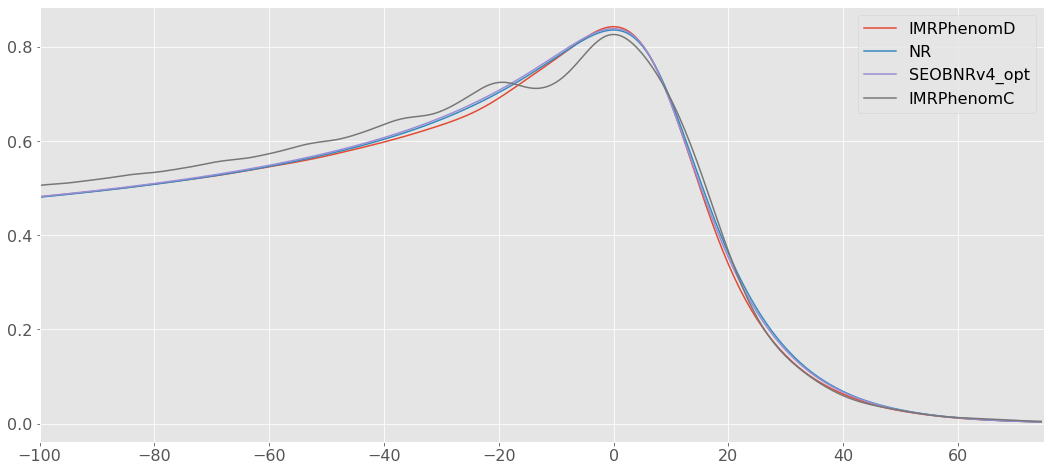

In [37]:
plt.figure(figsize=(18, 8))
plt.plot(times, training_data['amplitude'][training_data['mask']['IMRPhenomD'][0]], label='IMRPhenomD')
plt.plot(times, training_data['amplitude'][training_data['mask']['NR'][0]], label='NR')
plt.plot(times, training_data['amplitude'][training_data['mask']['SEOBNRv4_opt'][0]], label='SEOBNRv4_opt')
plt.plot(times, training_data['amplitude'][training_data['mask']['IMRPhenomC'][0]], label='IMRPhenomC')
plt.xlim(-100, 75)
plt.legend()

In [38]:
# model_to_index = dict(IMRPhenomD=0, NR=1, SEOBNRv4_opt=2)
model_to_index = dict(IMRPhenomC=0, IMRPhenomD=1, NR=2, SEOBNRv4_opt=3)

In [39]:
wf = wispy.waveutils.gen_model_waveforms(approx='IMRPhenomD', qlist=[1], dt=0.5, t_min=-500, t_max=75, nrfiles=None)[0]

In [40]:
wf.amp

array([0.15524236, 0.15527729, 0.15531223, ..., 0.0017075 , 0.00162471,
       0.00154663])

In [41]:
def match(h1, h2, times):

    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df

    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)

    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm

    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)


    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    res = ifft / h1h1 / h2h2 * 4 * dt

    return np.max(np.abs(res))

In [42]:
# https://stackoverflow.com/questions/31671999/python-different-size-subplots-in-matplotlib
def compare_with_models(approx, q):
    n = model_to_index[approx]
    h_hat, amp_hat, phase_hat = predict_wave([n], [q])
    
#     wf = wispy.waveutils.gen_model_waveforms(approx=approx, qlist=[q], dt=0.5, t_min=-500, t_max=75, nrfiles=None)[0]
    wf = wispy.waveutils.gen_model_waveforms(approx=approx, qlist=[q], dt=0.5, t_min=-2000, t_max=75, nrfiles=None)[0]
    
    
    match_result = match(np.real(h_hat[0]), np.real(wf.h22),  times)
    
    
    plt.figure(figsize=(22, 12))
    plt.subplot(3, 2, 1)
    plt.plot(times, wf.amp, label=approx)
    plt.plot(times, amp_hat[0], label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.subplot(3, 2, 2)
    plt.plot(times, wf.phase, label=approx)
    plt.plot(times, phase_hat[0], label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 2, 3)
    plt.plot(times, wf.amp-amp_hat[0], label='diff')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 2, 4)
    plt.plot(times, wf.phase-phase_hat[0], label='diff')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    
    plt.subplot(3, 1, 3)
    plt.plot(times, np.real(wf.h22), label=approx)
    plt.plot(times, np.real(h_hat[0]), label='model', ls='--')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
#     plt.xlim(-100, 100)
    
    plt.suptitle(f"q = {np.around(q, 3)}, match = {np.around(match_result, 8)}")

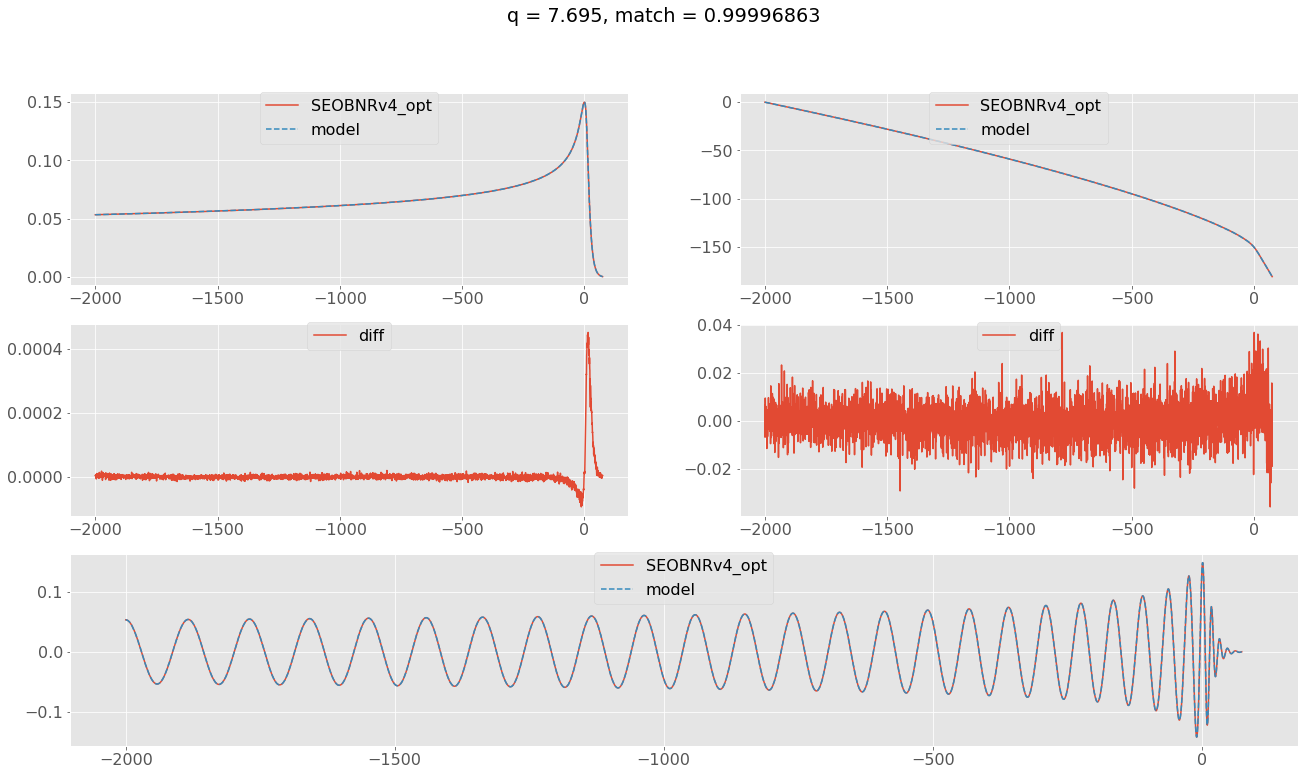

In [43]:
compare_with_models(approx='SEOBNRv4_opt', q=np.random.uniform(1, 10))

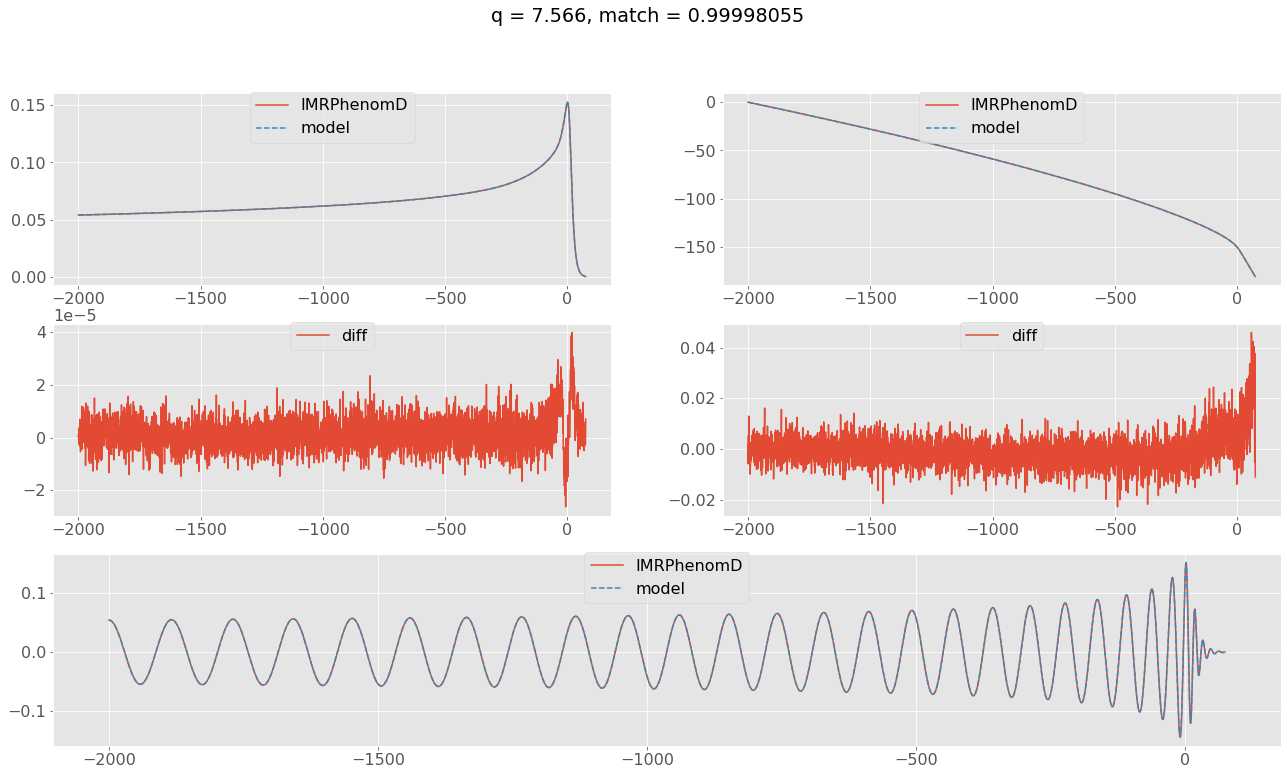

In [44]:
compare_with_models(approx='IMRPhenomD', q=np.random.uniform(1, 10))

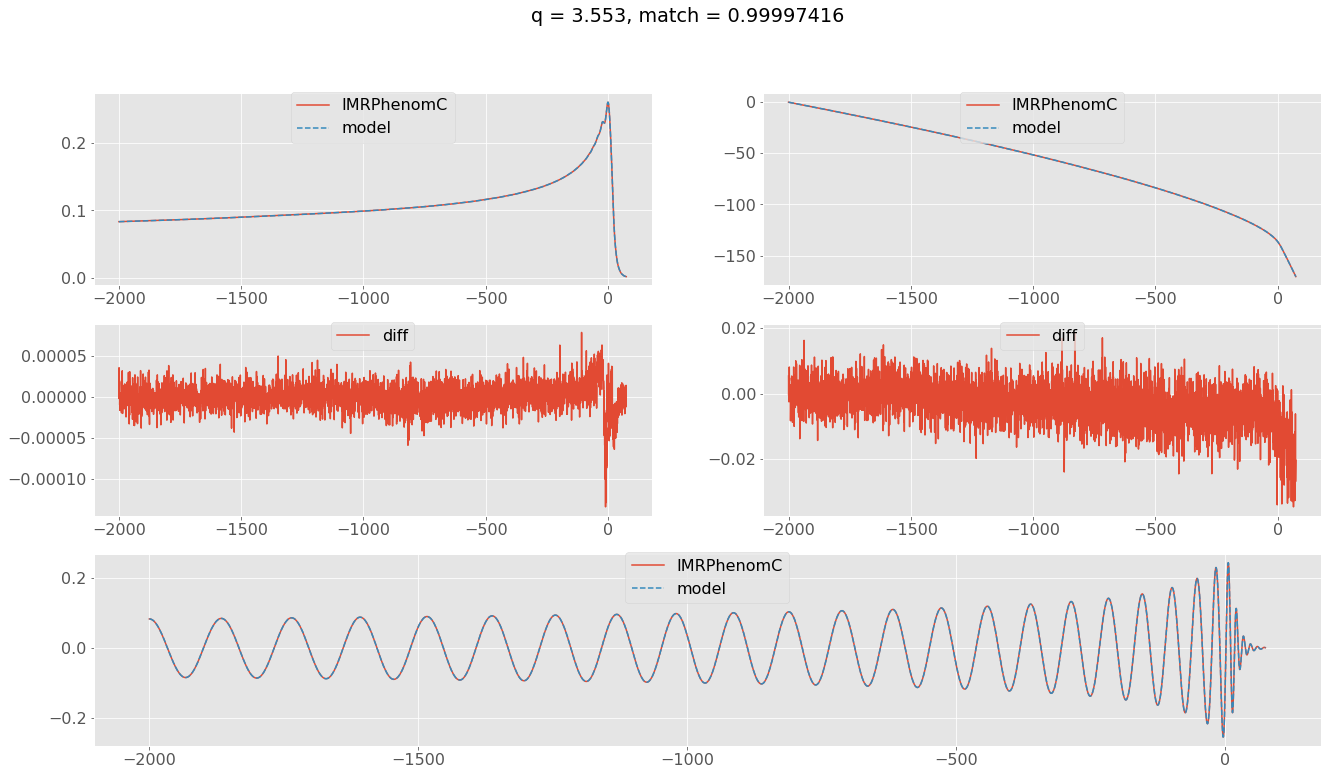

In [45]:
compare_with_models(approx='IMRPhenomC', q=np.random.uniform(1, 10))

# compute match as a function of model index

In [46]:
np.arange(4)

array([0, 1, 2, 3])

In [47]:
def matches_vs_model_index(approx_true="IMRPhenomD", q_true=1., approx_other="SEOBNRv4_opt"):
    
    num_models = len(model_to_index.keys())
    
    ns = np.linspace(0, 3, 1000)
    qs = np.repeat(q_true, len(ns))
    
    h_hats, _, _ = predict_wave(ns, qs)
    
#     t_min = -500
    t_min = -2000
    
    wf_true = wispy.waveutils.gen_model_waveforms(approx=approx_true, qlist=[q_true], dt=0.5, t_min=t_min, t_max=75, nrfiles=None)[0]
    wf_other = wispy.waveutils.gen_model_waveforms(approx=approx_other, qlist=[q_true], dt=0.5, t_min=t_min, t_max=75, nrfiles=None)[0]
    
    match_other = match(np.real(wf_true.h22), np.real(wf_other.h22), times)
    print(f"true match between {approx_true} and {approx_other} = {match_other}")
    
    
    match_results = np.array([match(np.real(h_hat), np.real(wf_true.h22), times) for h_hat in h_hats])
    
    plt.figure()
    plt.plot(ns, match_results)
    plt.axhline(match_other, c='k')
    plt.xlabel("abstract model parameter")
    
    # https://stackoverflow.com/questions/33446101/adding-secondary-x-axis-with-user-defined-list-of-coordinates
    axes1 = plt.gca()
    axes2 = axes1.twiny()
    axes2.set_xlim(axes1.get_xlim()) # make sure axes2 covers the same range
    axes2.set_xticks(np.arange(num_models))
    axes2.set_xticklabels([k for k in model_to_index.keys()], rotation=45, fontsize=10)
    axes2.set_xlabel("models")
    
    plt.show()
    plt.close()

true match between IMRPhenomD and SEOBNRv4_opt = 0.9951143443520083


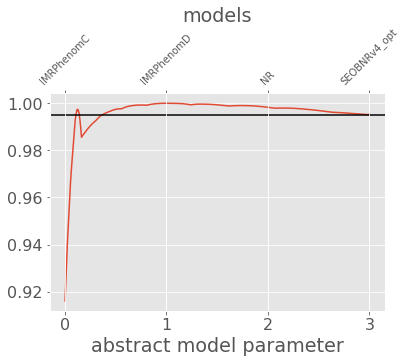

true match between SEOBNRv4_opt and IMRPhenomD = 0.9951143443520087


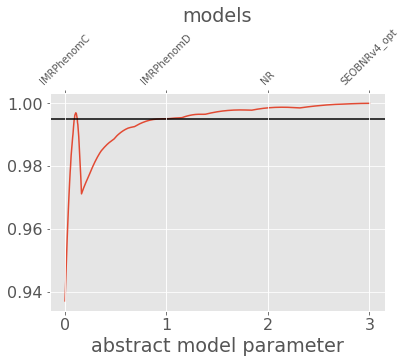

true match between IMRPhenomC and IMRPhenomD = 0.9169920894378432


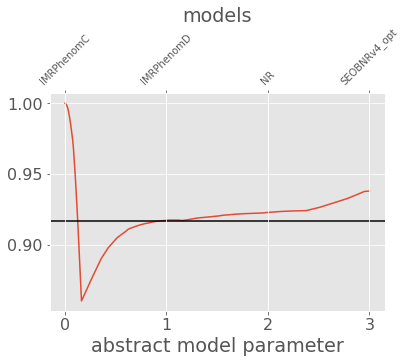

true match between IMRPhenomC and SEOBNRv4_opt = 0.9379888202859904


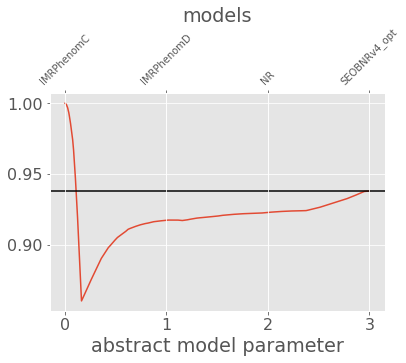

In [48]:
q_true = 4.
matches_vs_model_index(approx_true="IMRPhenomD", q_true=q_true, approx_other="SEOBNRv4_opt")
matches_vs_model_index(approx_true="SEOBNRv4_opt", q_true=q_true, approx_other="IMRPhenomD")
matches_vs_model_index(approx_true="IMRPhenomC", q_true=q_true, approx_other="IMRPhenomD")
matches_vs_model_index(approx_true="IMRPhenomC", q_true=q_true, approx_other="SEOBNRv4_opt")

# saving model

In [144]:
def make_tag(prefix):
    """
    use temp file and datetime to get a unique name that begins
    with 'prefix', has a middle that is the data and ends
    with a random string.

    by default prefix is 'exp' that is short for experiment.

    name template: '[prefix]_[%y%m%d]_[random]'
    """
    date_now = datetime.datetime.now().strftime("%y%m%d")
    with tempfile.NamedTemporaryFile(prefix=f"{prefix}_{date_now}_") as temp:
        tag = temp.name.split("/")[-1]
    return tag

In [148]:
def save_model(tag, model, history):
    print(f"making output directory: {tag}")
    os.makedirs(f"{tag}")

    model.save(os.path.join(tag, "model.h5"))
    
    wispy.model_utils.save_history(history, os.path.join(tag, "history.pickle"))

In [150]:
# save_amp = True
save_amp = False

# save_phase = True
save_phase = False

In [152]:
if save_amp:
    tag = make_tag('amplitude')
    save_model(tag, model_amp, amp_history.history)

if save_phase:
    tag = make_tag('phase')
    save_model(tag, model_phase, phase_history.history)

making output directory: amplitude_210330_ugngmn9d
making output directory: phase_210330_xon70_fh


In [158]:
# test_amp = tf.keras.models.load_model("amplitude_210330_ugngmn9d/model.h5", compile=False)
# test_phase = tf.keras.models.load_model("phase_210330_xon70_fh/model.h5", compile=False)